# Модуль 9. **Підбір гіперпараметрів НМ**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import keras

from keras.layers import Dense, Dropout
from keras.models import Sequential

from keras import optimizers
from keras import losses
from keras import metrics
import copy

In [2]:
# константи кольору
YELLOW = "\033[33m"
LIGHTBLUE = "\033[94m"
GRAY_BACK = "\033[100m"
RESET = "\033[0m"

### Завдання

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету _fasion_mnist_ (https://www.tensorflow.org/datasets/catalog/fashion_mnist).

Вам належить запропонувати свою власну архітектуру мережі. Точність найнаївнішої, але адекватної нейромережі становить приблизно 91%. Точність вашої моделі повинна бути не нижчою за цей показник. Щоб досягти таких значень вам знадобиться поекспериментувати з гіперпараметрами мережі:

* кількість шарів;
* кількість нейронів;
* функції активації;
* кількість епох;
* розмір батчу;
* вибір оптимізатора;
* різні техніки регуляризації і т.д.

Використайте вивчені техніки виявлення проблем навчання нейронної мережі, і потім поекспериментуйте.

    Завантаження та аналіз даних

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

In [4]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [5]:
# from https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md#labels
labels_description = {
    "Label": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    "Description": [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ],
}
labels = pd.DataFrame(labels_description)

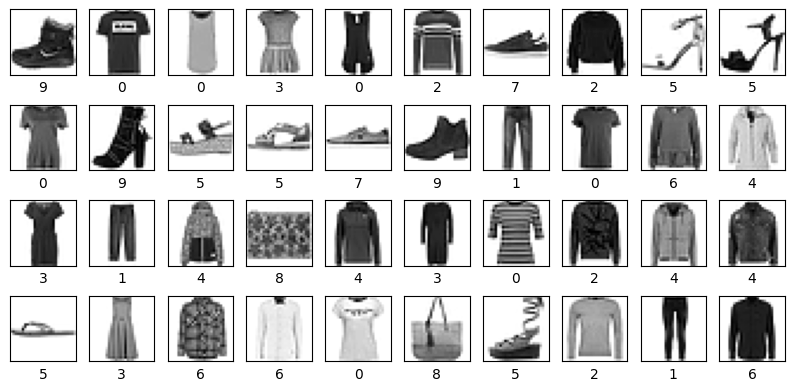

 Label Description
     0 T-shirt/top
     1     Trouser
     2    Pullover
     3       Dress
     4        Coat
     5      Sandal
     6       Shirt
     7     Sneaker
     8         Bag
     9  Ankle boot


In [6]:
plt.figure(figsize=(10, 6))
for i in range(40):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show() 

print(labels.to_string(index=False))

### Допоміжні функції

    Функція друку поточних параметрів
######      Аргументи: <br>1.  parameters - Поточні параметри для тренування моделі<br>2. text - Заголовок списку параметрів

In [7]:
def print_parameters(parameters: dict, text='Поточні параметри:'):
    print(f"{LIGHTBLUE}{text}{RESET}")
    # print("-" * 18)
    for k, val in parameters.items():
        print(f" {k} \t= {YELLOW}{val}{RESET}")

    Функція відображення графіків історії точності та втрат
######      Аргументи: <br>1. history - дані історії точності та втрат<br>2.  parameters - Поточні параметри тренування моделі

In [8]:
def plt_history(history, parameters):

    dict_data = {
        "accuracy": "Точність на тренувальному наборі",
        "val_accuracy": "Точність на тестовому наборі",
        "loss": "Втрати на тренувальному наборі",
        "val_loss": "Втрати на тестовому наборі",
    }
    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    print_parameters(parameters)

    for data_, label_ in dict_data.items():
        plt.plot(
            epochs,
            history.history[data_],
            color=color_loss if (data_[-4:] == "loss") else color_acc,
            linestyle=linestyle_test if (data_[:3] == "val") else linestyle_train,
            label=label_,
        )

    # plt.title("Точність та втрати на тренувальному та тестовому наборах")
    plt.xlabel("Епоха")
    plt.ylabel("Метрика")
    plt.legend()
    plt.show()

    Функція підготовки моделі
######      Аргументи: <br>1. model_func - Функція, що містить модель для тренування<br>2. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>3. summary - Параметр для керування виводом даних моделі

In [9]:
def prepare_model(
    model_func,
    hidden_units,
    activation,
    dropout_rate,
    optimizer,
    loss_function,
    metrics,
    summary,
):
    model = model_func(hidden_units, activation, dropout_rate)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    if summary:
        model.summary()

    return model

    Функція тренування моделі
######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2. model_func - Функція, що містить модель для тренування<br>3. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>4. epochs, batch_size - Параметри для тренування моделі<br>4. verbose, summary - Параметри для керування виводом даних навчання моделі

In [10]:
def train_model(
    train_images,
    train_labels,
    test_images,
    test_labels,
    model_func,
    epochs,
    batch_size,
    dropout_rate,
    loss_function,
    optimizer,
    hidden_units,
    activation,
    metrics,
    verbose=0,
    summary=0,
):

    model = prepare_model(
        model_func,
        hidden_units,
        activation,
        dropout_rate,
        optimizer,
        loss_function,
        metrics,
        summary,
    )

    history = model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, test_labels),
        verbose=verbose,
    )

    print("          Точність:")
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print("          тренувальні дані: ", YELLOW, train_acc, RESET)

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print("          тестові дані:     ", YELLOW, test_acc, RESET)

    return history, test_acc

      Функція пошуку оптимальних параметрів

######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2.  parameters - Параметри для тренування моделі<br>3.  optimal_parameters - Оптимальні параметри. Спочатку "зі стелі", під час аналізу змінюються на оптимальні<br>4.  study_sequence - Послідовність параметрів, що мають перевірятися<br>5. model_func - Функція, що містить модель для тренування

In [11]:
def find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    model_func,
    verbose=0,
):

    best_accuracy = 0.0
    best_parameters = {}

    for param in study_sequence:

        print(f"{GRAY_BACK}{"=" * 50}{RESET}")
        print(f"Пошук оптимального значення параметра: {YELLOW}{param} {RESET}")
        print(f"{GRAY_BACK}{"=" * 50}{RESET}")

        param_values = parameters[param]
        best_value = optimal_parameters[param]

        for value in param_values:
            optimal_parameters[param] = value

            print("-" * 50)
            print(f"Тестується значення: {YELLOW}{param} = {value}{RESET}")
            print("-" * 50)

            history, test_acc = train_model(
                train_images,
                train_labels,
                test_images,
                test_labels,
                model_func,
                verbose=verbose,
                **optimal_parameters,
            )

            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_parameters = copy.deepcopy(optimal_parameters)
                best_value = value

            # Plotting training history
            plt_history(history, optimal_parameters)

        # Update optimal parameter for the current parameter
        optimal_parameters[param] = best_value

        print(
            f"{LIGHTBLUE} Оптимальне значення параметра {YELLOW}{param} = {best_value}"
        )
        print(f"{LIGHTBLUE}   точність на тестових даних: {YELLOW}{best_accuracy}{RESET}", end='\n\n')

    return best_parameters, best_accuracy

    Параметри для тренування моделей

In [12]:
# Оптимальні параметри.
# Спочатку "зі стелі", під час навчання змінюються на справді оптимальні.
optimal_parameters = {
    "epochs": 10,
    "batch_size": 8,
    "dropout_rate": 0.2,
    "loss_function": "sparse_categorical_crossentropy",
    "optimizer": "adam",
    "hidden_units": 128,
    "activation": "relu",
    "metrics": ["accuracy"],
}

# Списки параметрів, що мають бути досліджені
parameters = {
    "epochs": [20, 50, 100],
    # "epochs": [10, 20, 50, 100],

    # "batch_size": [8, 16, 32],
    "batch_size": [8, 32, 64, 128, 256],

    "dropout_rate": [0.1, 0.2],
    # "dropout_rate": [0.0, 0.1, 0.2, 0.3],

    "loss_function": [
        "sparse_categorical_crossentropy",
        # "binary_crossentropy",
        # "mean_squared_error",
    ],

    "optimizer": ["adam", "sgd", "rmsprop"],
    # "optimizer": ["adam", "rmsprop", "sgd", "adagrad", "adadelta"],

    "hidden_units": [64, 128, 256, 512],
    # "hidden_units": [32, 64, 128, 256],

    "activation": ["relu", "sigmoid"],
    # "activation": ["relu", "sigmoid", "tanh"],

    "metrics": [
        "accuracy",
    ],
}

***
### **Модель для тренування 1** 
***
     Шари: 
1. Вхідний шар: Flatten - перетворює вхідні зображення розміром 28x28 у вектор.
2. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць та активаційною функцією, які вказані у параметрах.
3. Вихідний шар: Dense з 10 одиницями та активаційною функцією "softmax", яка використовується для класифікації на 10 класів.

In [13]:
# Видає помилку: 
# UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. 
# When using Sequential models, prefer using an `Input(shape)` object 
# as the first layer in the model instead.

# def model_1(hidden_units, activation, dropout_rate):
#     return models.Sequential(
#         [
#             layers.Flatten(input_shape=(28, 28), name="Input"),
#             layers.Dense(hidden_units, activation=activation, name="Hidden_layer"),
#             layers.Dropout(dropout_rate, name="Dropout_layer"),
#             layers.Dense(10, activation="softmax", name="Output"),
#         ]
#     )

In [14]:
# такий варіант помилки не видає, працює так само
# TODO розібратися
def model_1(hidden_units, activation, dropout_rate):
    # # Визначте вхідний шар
    inputs = Input(shape=(28, 28), name="Input")

    # # Додайте шари до моделі
    x = layers.Flatten(name='Flatten')(inputs)
    x = layers.Dense(hidden_units, activation=activation, name="Hidden_layer")(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer")(x)
    outputs = layers.Dense(10, activation="softmax", name="Output")(x)

    # # Створіть модель
    model = Model(inputs, outputs)
    return model

    Параметри, для навчання моделі 1
###### study_sequence - Послідовність дослідження

In [15]:
study_sequence = [
    "batch_size",
    "dropout_rate",
    "hidden_units",
    # "loss_function",
    "optimizer",
    "activation",
    # "metrics",
    "epochs",
]

    Пошук оптимальних параметрів для вказаної моделі 
###### model_1 - функція що досліджується

Пошук оптимального значення параметра: batch_size 
--------------------------------------------------
Тестується значення: batch_size = 8
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 925us/step - accuracy: 0.8959 - loss: 0.2700
          тренувальні дані:   0.8948833346366882 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8610 - loss: 0.3816
          тестові дані:       0.8629000186920166 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 8
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


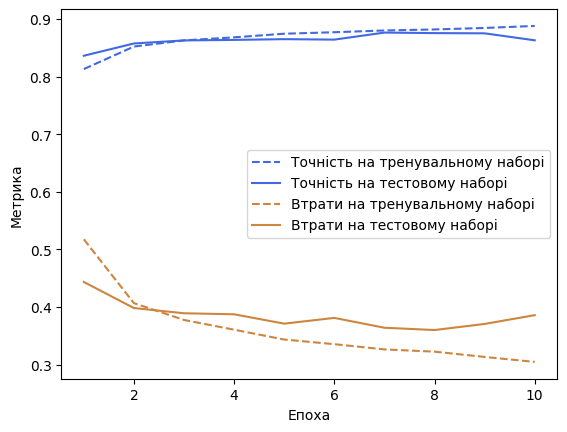

--------------------------------------------------
Тестується значення: batch_size = 32
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 891us/step - accuracy: 0.9103 - loss: 0.2352
          тренувальні дані:   0.9102500081062317 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.8818 - loss: 0.3285
          тестові дані:       0.883400022983551 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


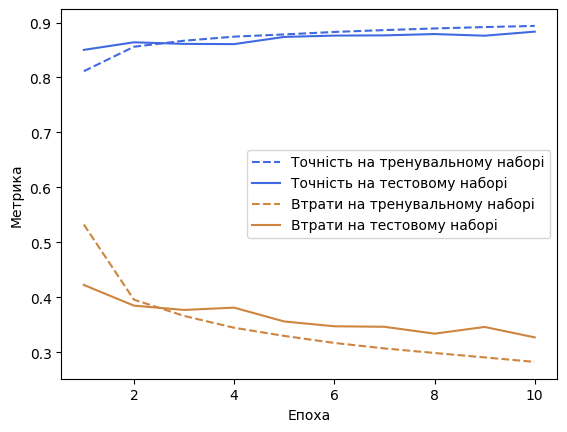

--------------------------------------------------
Тестується значення: batch_size = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 881us/step - accuracy: 0.9118 - loss: 0.2360
          тренувальні дані:   0.9110000133514404 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.8857 - loss: 0.3220
          тестові дані:       0.8838000297546387 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


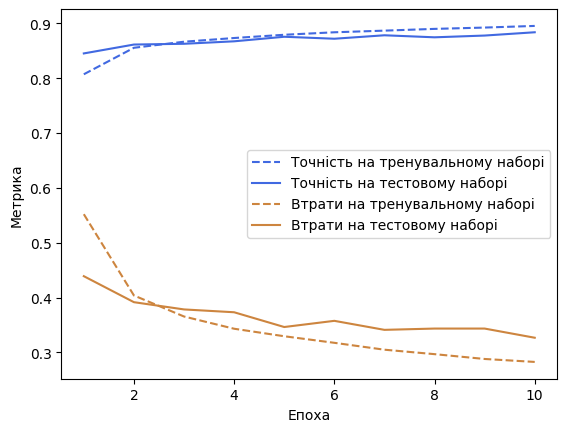

--------------------------------------------------
Тестується значення: batch_size = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 804us/step - accuracy: 0.9061 - loss: 0.2543
          тренувальні дані:   0.9048500061035156 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.8751 - loss: 0.3309
          тестові дані:       0.8763999938964844 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


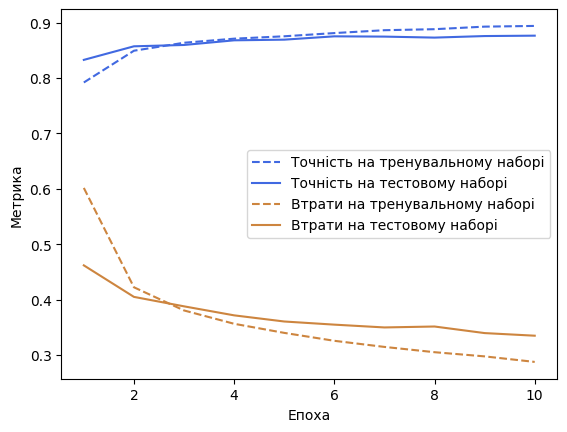

--------------------------------------------------
Тестується значення: batch_size = 256
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 793us/step - accuracy: 0.9022 - loss: 0.2705
          тренувальні дані:   0.9009333252906799 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.8784 - loss: 0.3372
          тестові дані:       0.8781999945640564 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 256
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


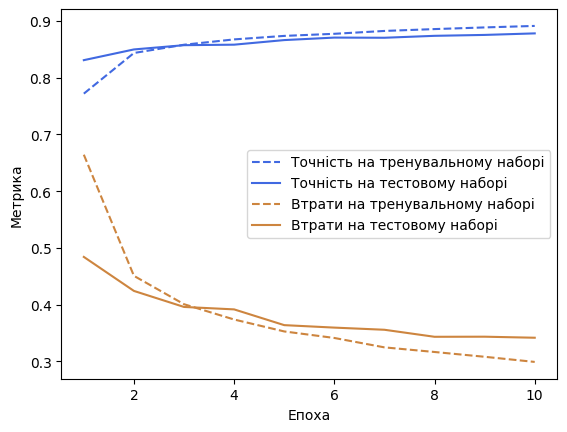

 Оптимальне значення параметра batch_size = 64
   точність на тестових даних: 0.8838000297546387

Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 860us/step - accuracy: 0.9147 - loss: 0.2316
          тренувальні дані:   0.9141499996185303 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.8849 - loss: 0.3277
          тестові дані:       0.8845000267028809 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


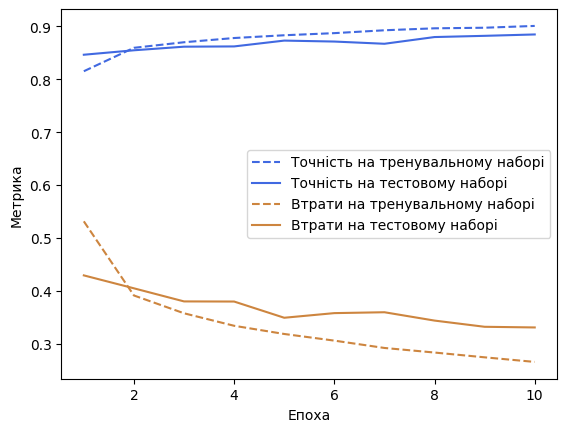

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - accuracy: 0.9113 - loss: 0.2368
          тренувальні дані:   0.9107499718666077 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.8818 - loss: 0.3300
          тестові дані:       0.8808000087738037 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


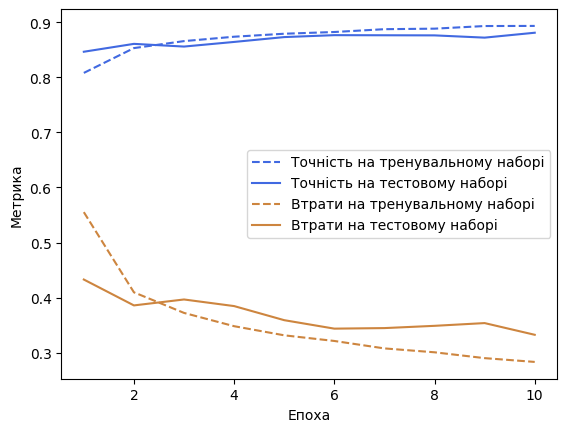

 Оптимальне значення параметра dropout_rate = 0.1
   точність на тестових даних: 0.8845000267028809

Пошук оптимального значення параметра: hidden_units 
--------------------------------------------------
Тестується значення: hidden_units = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.9022 - loss: 0.2641
          тренувальні дані:   0.90256667137146 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.8766 - loss: 0.3440
          тестові дані:       0.8762999773025513 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']


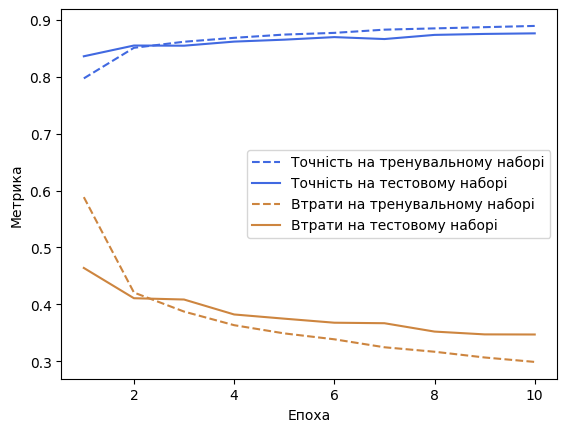

--------------------------------------------------
Тестується значення: hidden_units = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9103 - loss: 0.2435
          тренувальні дані:   0.9093166589736938 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.8794 - loss: 0.3402
          тестові дані:       0.8781999945640564 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


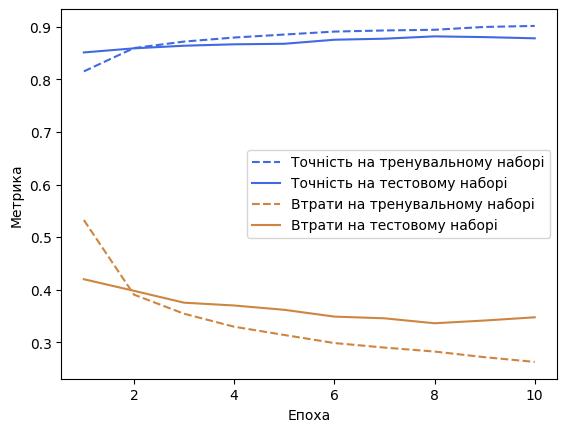

--------------------------------------------------
Тестується значення: hidden_units = 256
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - accuracy: 0.9163 - loss: 0.2253
          тренувальні дані:   0.9162499904632568 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.8876 - loss: 0.3317
          тестові дані:       0.8877999782562256 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


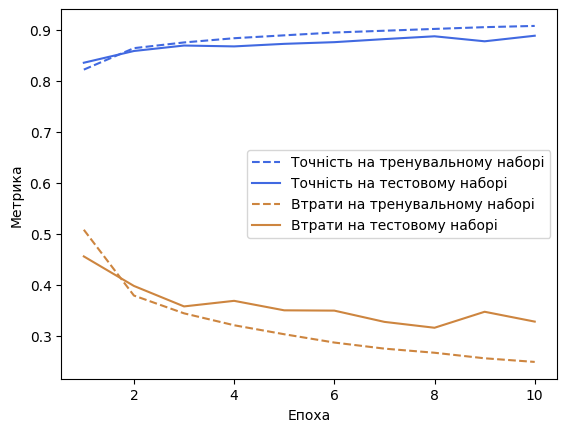

--------------------------------------------------
Тестується значення: hidden_units = 512
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9197 - loss: 0.2165
          тренувальні дані:   0.9188166856765747 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8860 - loss: 0.3210
          тестові дані:       0.8866000175476074 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']


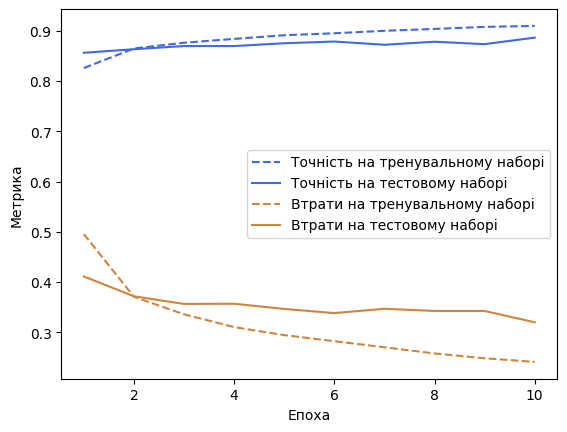

 Оптимальне значення параметра hidden_units = 256
   точність на тестових даних: 0.8877999782562256

Пошук оптимального значення параметра: optimizer 
--------------------------------------------------
Тестується значення: optimizer = adam
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 862us/step - accuracy: 0.9121 - loss: 0.2302
          тренувальні дані:   0.9102833271026611 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8787 - loss: 0.3427
          тестові дані:       0.8784000277519226 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


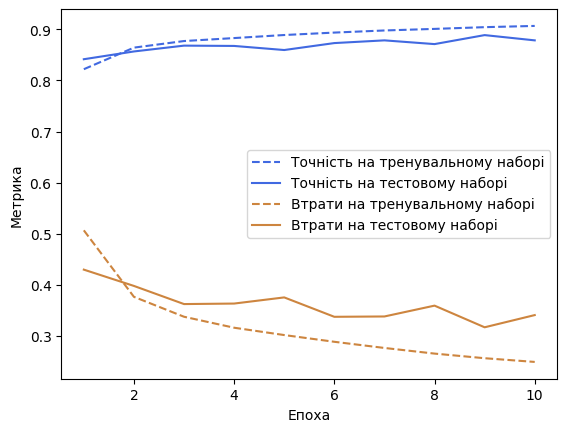

--------------------------------------------------
Тестується значення: optimizer = sgd
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 990us/step - accuracy: 0.8631 - loss: 0.3970
          тренувальні дані:   0.8615000247955322 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.8499 - loss: 0.4288
          тестові дані:       0.8443999886512756 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= sgd
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


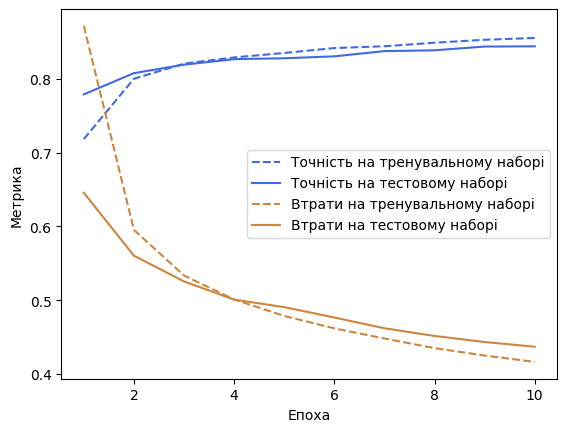

--------------------------------------------------
Тестується значення: optimizer = rmsprop
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 883us/step - accuracy: 0.9185 - loss: 0.2203
          тренувальні дані:   0.9180333614349365 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.8853 - loss: 0.3469
          тестові дані:       0.8866999745368958 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


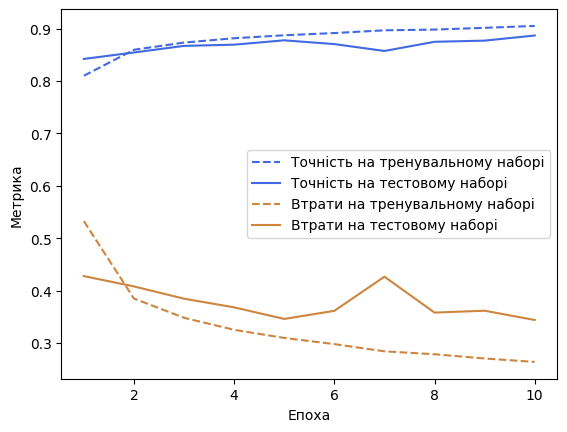

 Оптимальне значення параметра optimizer = adam
   точність на тестових даних: 0.8877999782562256

Пошук оптимального значення параметра: activation 
--------------------------------------------------
Тестується значення: activation = relu
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 900us/step - accuracy: 0.9057 - loss: 0.2518
          тренувальні дані:   0.9053166508674622 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.8739 - loss: 0.3645
          тестові дані:       0.8744000196456909 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


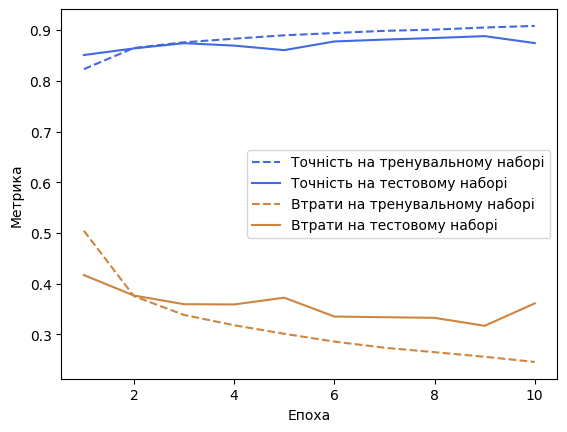

--------------------------------------------------
Тестується значення: activation = sigmoid
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 987us/step - accuracy: 0.9099 - loss: 0.2461
          тренувальні дані:   0.9092833399772644 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.8821 - loss: 0.3272
          тестові дані:       0.882099986076355 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= sigmoid
 metrics 	= ['accuracy']


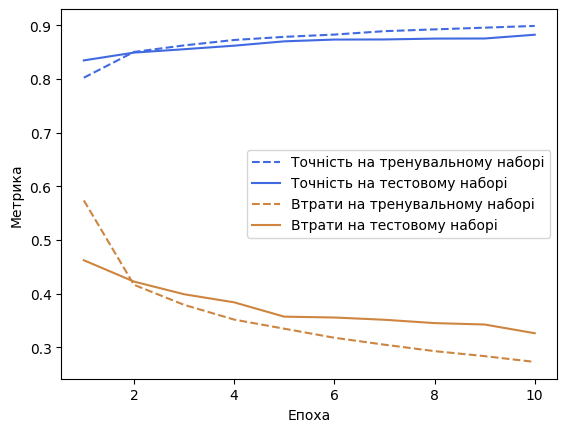

 Оптимальне значення параметра activation = relu
   точність на тестових даних: 0.8877999782562256

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 20
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 989us/step - accuracy: 0.9394 - loss: 0.1639
          тренувальні дані:   0.9395999908447266 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.8921 - loss: 0.3318
          тестові дані:       0.8895000219345093 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


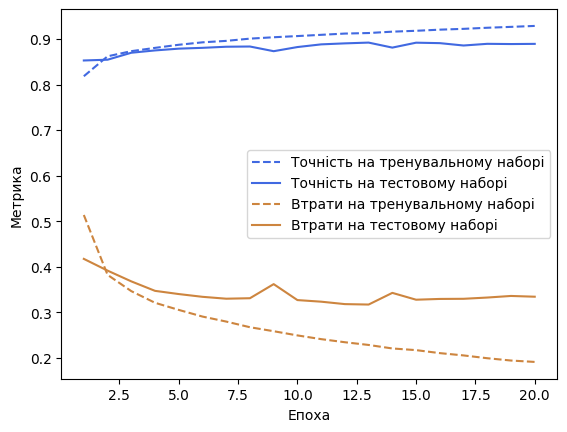

--------------------------------------------------
Тестується значення: epochs = 50
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 936us/step - accuracy: 0.9684 - loss: 0.0862
          тренувальні дані:   0.9673500061035156 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.8953 - loss: 0.4059
          тестові дані:       0.8952999711036682 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


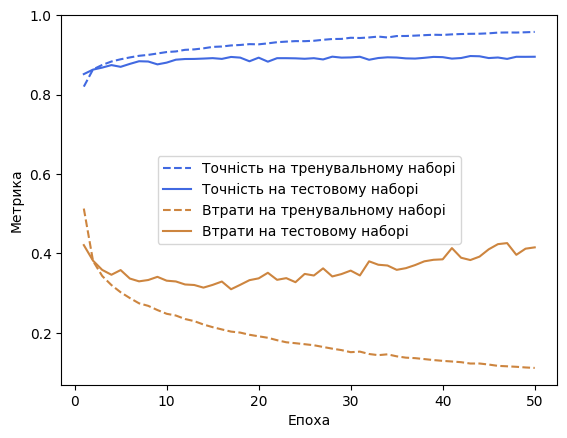

--------------------------------------------------
Тестується значення: epochs = 100
--------------------------------------------------


In [ ]:
best_parameters, best_accuracy = find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    model_1,
)

In [847]:
print_parameters(best_parameters, "Оптимальні параметри для model_1")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_1
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']
 Точність:        0.8968999981880188


<div class="alert alert-block alert-info">
<b>Висновки model_1:</b> 
<p>Отримано оптимальні параметри для базової моделі з одним прихованим шаром<br>Навіть за оптимізованих параметрів точність моделі (<b>89.68%</b>) недостатня</p>
</div>

In [ ]:
model_1.save("hw_09_model.keras")

***
### **Модель для тренування 2** 
***
_Ускладнимо модель, додавши два додаткових Dense-шари (3 та 4)_

     Шари: 
1. Вхідний шар: Flatten - перетворює вхідні зображення розміром 28x28 у вектор.
2. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць та активаційною функцією, які вказані у параметрах.
3. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць в 2 рази менше, ніж у шара 2 та активаційною функцією, яка вказані у параметрах.
4. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць в 4 рази менше, ніж у шара 2 та активаційною функцією, яка вказані у параметрах.
5. Вихідний шар: Dense з 10 одиницями та активаційною функцією "softmax", яка використовується для класифікації на 10 класів.

_також скоротимо перелік параметрів, що досліджуються до трьох_
1. 'dropout_rate',
2. 'hidden_units',
3. 'epochs'

In [848]:
# def model_2(hidden_units, activation, dropout_rate):
#     return models.Sequential(
#         [
#             layers.Flatten(input_shape=(28, 28)),
#             layers.Dense(hidden_units, activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(int(hidden_units / 2), activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(int(hidden_units / 4), activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(10, activation="softmax"),
#         ]
#     )

In [849]:
# такий варіант помилки не видає, працює так само
def model_2(hidden_units, activation, dropout_rate):
    # # Визначте вхідний шар
    inputs = Input(shape=(28, 28), name="Input")

    # # Додайте шари до моделі
    x = layers.Flatten(name="Flatten")(inputs)
    x = layers.Dense(hidden_units, activation=activation, name="Hidden_layer_1")(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer_1")(x)
    x = layers.Dense(
        int(hidden_units / 2), activation=activation, name="Hidden_layer_2"
    )(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer_2")(x)
    x = layers.Dense(
        int(hidden_units / 4), activation=activation, name="Hidden_layer_3"
    )(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer_3")(x)
    outputs = layers.Dense(10, activation="softmax", name="Output")(x)

    # # Створіть модель
    model = Model(inputs, outputs)
    return model

In [850]:
study_sequence = [
    # "batch_size",
    "dropout_rate",
    "hidden_units",
    # "loss_function",
    # "optimizer",
    # "activation",
    # "metrics",
    "epochs",
]

Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9766 - loss: 0.0607
          тренувальні дані:   0.9766666889190674 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8983 - loss: 0.4620
          тестові дані:       0.8981000185012817 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


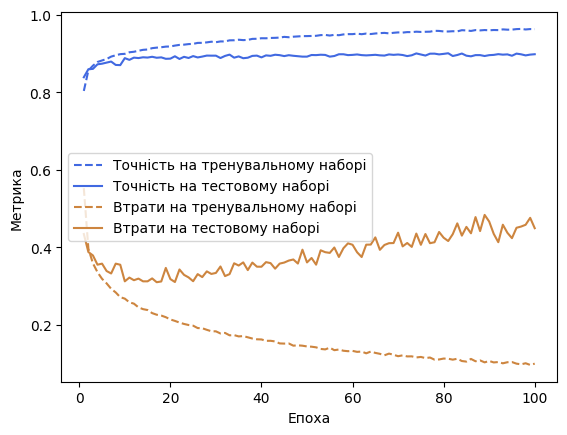

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9587 - loss: 0.1099
          тренувальні дані:   0.9581833481788635 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8964 - loss: 0.4152
          тестові дані:       0.8985000252723694 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


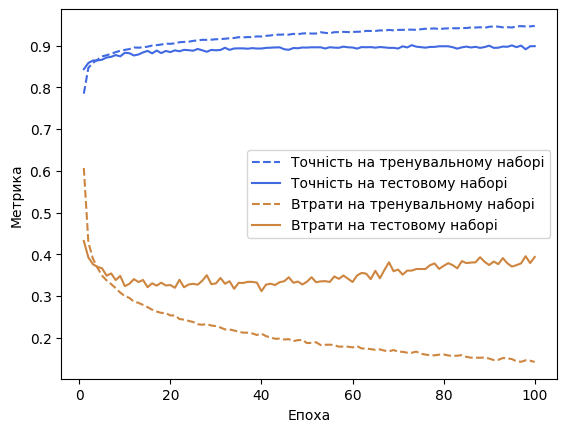

 Оптимальне значення параметра dropout_rate = 0.2
   точність на тестових даних: 0.8985000252723694

Пошук оптимального значення параметра: hidden_units 
--------------------------------------------------
Тестується значення: hidden_units = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 851us/step - accuracy: 0.9240 - loss: 0.2082
          тренувальні дані:   0.9232833385467529 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.8851 - loss: 0.3780
          тестові дані:       0.8835999965667725 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']


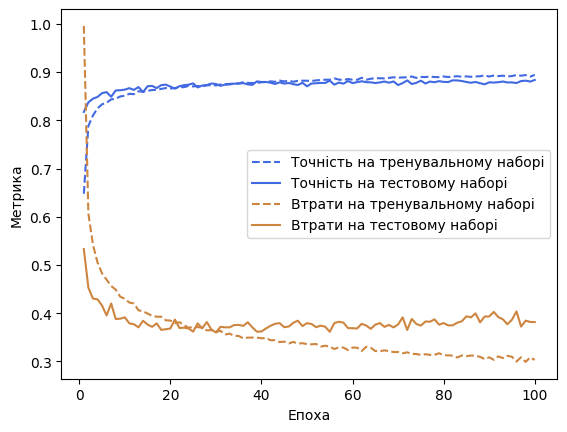

--------------------------------------------------
Тестується значення: hidden_units = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 985us/step - accuracy: 0.9465 - loss: 0.1379
          тренувальні дані:   0.946316659450531 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.8946 - loss: 0.3894
          тестові дані:       0.8914999961853027 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


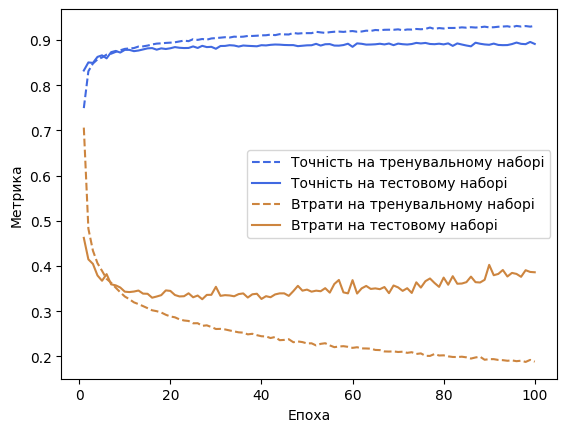

--------------------------------------------------
Тестується значення: hidden_units = 256
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9671 - loss: 0.0906
          тренувальні дані:   0.9673166871070862 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8971 - loss: 0.4027
          тестові дані:       0.8960999846458435 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


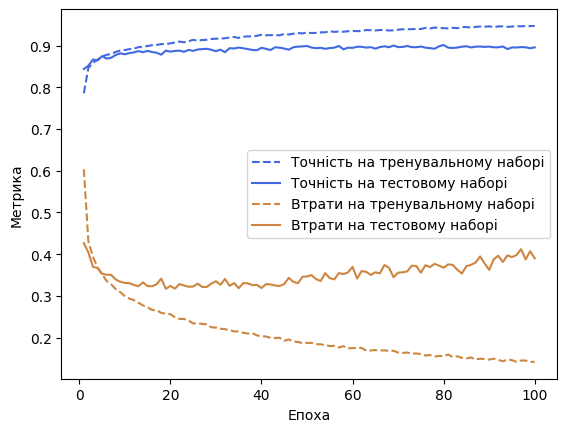

--------------------------------------------------
Тестується значення: hidden_units = 512
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9696 - loss: 0.0852
          тренувальні дані:   0.968500018119812 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9026 - loss: 0.4354
          тестові дані:       0.9027000069618225 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']


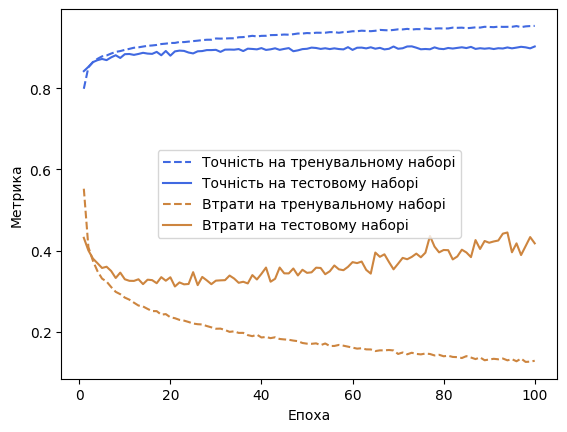

 Оптимальне значення параметра hidden_units = 512
   точність на тестових даних: 0.9027000069618225

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 20
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9226 - loss: 0.2010
          тренувальні дані:   0.9218000173568726 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8836 - loss: 0.3274
          тестові дані:       0.8859999775886536 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']


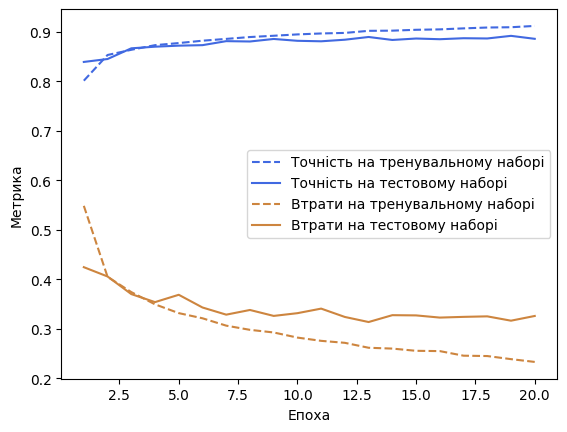

--------------------------------------------------
Тестується значення: epochs = 50
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9506 - loss: 0.1250
          тренувальні дані:   0.9503999948501587 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8950 - loss: 0.3704
          тестові дані:       0.8981999754905701 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']


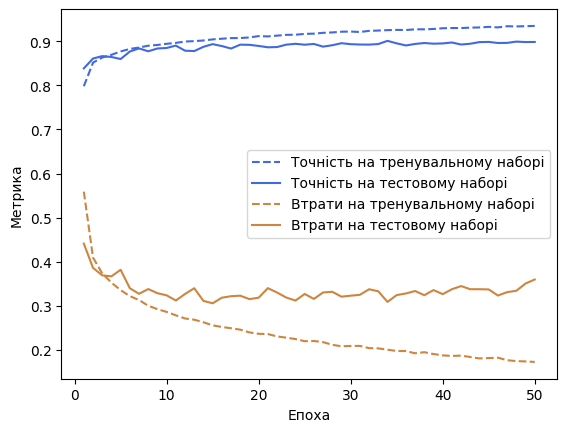

--------------------------------------------------
Тестується значення: epochs = 100
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9668 - loss: 0.0875
          тренувальні дані:   0.9664999842643738 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8975 - loss: 0.4296
          тестові дані:       0.8996000289916992 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']


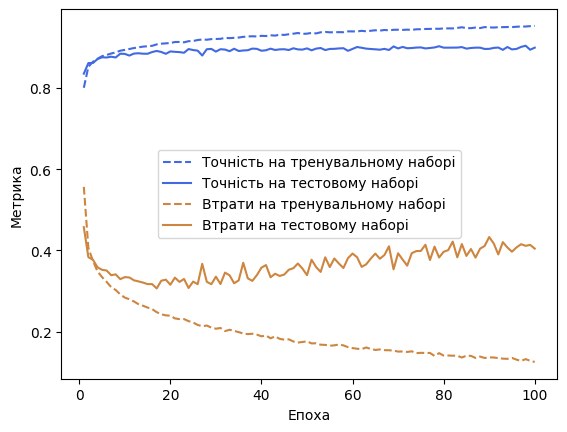

 Оптимальне значення параметра epochs = 100
   точність на тестових даних: 0.9027000069618225



In [851]:
best_parameters, best_accuracy = find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    model_2,
)

In [852]:
print_parameters(best_parameters, "Оптимальні параметри для model_2")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_2
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']
 Точність:        0.9027000069618225


<div class="alert alert-block alert-info">
<b>Висновки model_2:</b> 
<p>Отримано оптимальні параметри для ускладненої моделі з трьома прихованими шарами<br>Спостерігається <b>невеличке покращення</b> роботи моделі після її ускладнення<br>
<b>Точність</b> на тестових даних змінилася з <b>89.68%</b> до <b>90.27%</b></p>
<p>Оптимальні параметри змінилися тільки в одному пункті: <br>
 - hidden_units було 256 стало 512</p>
</div>

In [961]:
model_2.save('hw_09_model.keras')

***
### **Модель для тренування 2.1** 
***


     Модель model_2_1 ідентична моделі model_2 

In [1005]:
def model_2_1(hidden_units, activation, dropout_rate):
    # # Визначте вхідний шар
    inputs = Input(shape=(28, 28), name="Input")

    # # Додайте шари до моделі
    x = layers.Flatten(name="Flatten")(inputs)
    x = layers.Dense(hidden_units, activation=activation, name="Hidden_layer_1")(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer_1")(x)
    x = layers.Dense(
        int(hidden_units / 2), activation=activation, name="Hidden_layer_2"
    )(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer_2")(x)
    x = layers.Dense(
        int(hidden_units / 4), activation=activation, name="Hidden_layer_3"
    )(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer_3")(x)
    outputs = layers.Dense(10, activation="softmax", name="Output")(x)

    # # Створіть модель
    model = Model(inputs, outputs)
    return model

     Оптимальні параметри, що було визначено під час дослідження 

In [1006]:
epochs = 100
batch_size = 64
dropout_rate = 0.2
loss_function = "sparse_categorical_crossentropy"
optimizer = "adam"
hidden_units = 512
activation = "relu"
metrics = ["accuracy"]

     Створення моделі 

In [1007]:
model = prepare_model(
    model_2_1,
    hidden_units,
    activation,
    dropout_rate,
    optimizer,
    loss_function,
    metrics,
    summary=1,
)

Model: "functional_704"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_layer_1 (Dense)          │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_layer_1 (Dropout)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_layer_2 (Dense)          │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_layer_2 (Dropout)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_layer_3 (Dense)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_layer_3 (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

     Додавання до моделі callbacks 

In [1008]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.4, patience=10, min_lr=1e-8
)

     Тренування моделі 

In [1009]:
history = model.fit(
    train_images,
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    # callbacks=[early_stopping_callback, reduce_lr_callback],
    callbacks=[reduce_lr_callback],
    verbose=0,
)

In [1010]:
print("          Точність:")
train_loss, train_acc = model.evaluate(train_images, train_labels)
print("          тренувальні дані: ", YELLOW, train_acc, RESET)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("          тестові дані:     ", YELLOW, test_acc, RESET)


          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9761 - loss: 0.0621
          тренувальні дані:   0.975600004196167 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9047 - loss: 0.4399
          тестові дані:       0.9071999788284302 


Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']


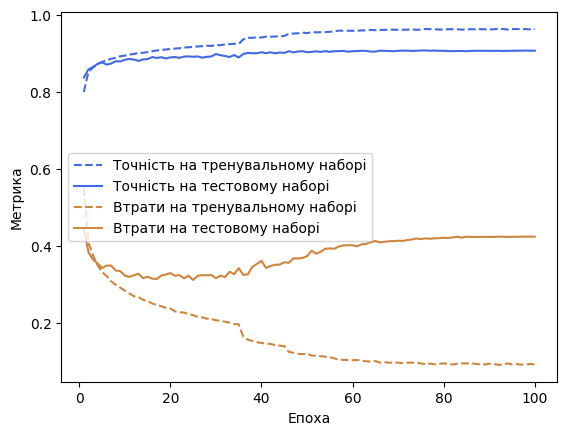

In [1011]:
plt_history(history, optimal_parameters)

In [1012]:
print_parameters(best_parameters, "Оптимальні параметри для model_1")
print(f" Точність:        {YELLOW}{test_acc}")

Оптимальні параметри для model_1
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']
 Точність:        0.9071999788284302


<div class="alert alert-block alert-info">
<b>Висновки:</b> 
<p>Додавання callbck'у LearningRateScheduler дозволило покращити роботу моделі<br>Точність сягнула <b>90.72%</p>
</div>